
# Supernovae distances and redshifts (part 2)

## Tasks - part 1

First let's fit our supernova synthetic data from last time using GPR.

- The key ingredient in getting a good GPR fit is the choice of the kernel and its parameters.
- Check out what's available in the kernels submodule of [sklearn.gaussian_process](https://scikit-learn.org/stable/api/index.html)
- Hint. Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.

Note. We have time constraints, so feel free to tweak the hyperparameters manually while in class. But, of course, a publication-quality result will require a cross-validation analysis. (Do this at home before the exam?)


### Fit with GPR


In [55]:
import numpy as np
import matplotlib.pyplot as plt
from astroML.datasets import generate_mu_z
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from astropy.cosmology import LambdaCDM, Planck18

import emcee
import corner

import scipy.stats
import dynesty
from dynesty import NestedSampler
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

from sklearn.neighbors import KernelDensity
import scipy.interpolate

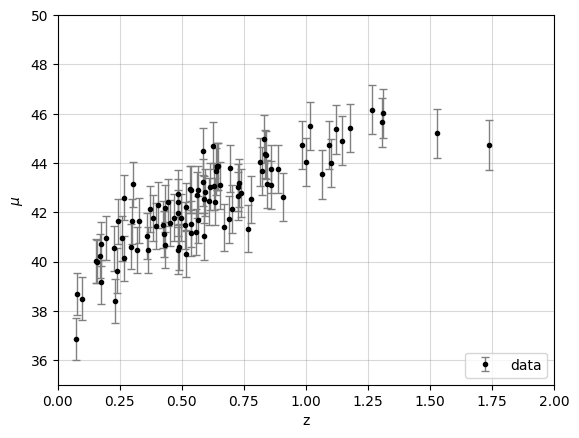

In [2]:
N = 100     # Number of samples to generate
z_sample, mu_sample, dmu = generate_mu_z(N, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=3, lw=1,label='data')
plt.xlabel('z')
plt.ylabel('$\\mu$')
plt.legend(loc='lower right')
plt.grid(alpha=0.3, c='gray')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

In [3]:
grid = np.linspace(0, 2, 100)[1:]

kernel = kernels.ConstantKernel(1.0, (1e-3, 1e3)) * kernels.RBF(1.0, (1e-3, 1e3))
gp = GaussianProcessRegressor(kernel=kernel, alpha=dmu**2)

gp.fit(z_sample[:, np.newaxis], mu_sample[:, np.newaxis])
mu_pred, sigma_pred = gp.predict(grid[:, np.newaxis], return_std=True)

print(gp.kernel_)

30.7**2 * RBF(length_scale=3.9)


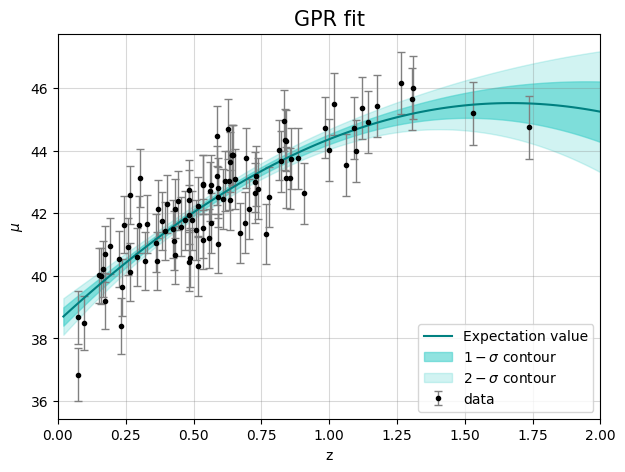

In [4]:
plt.figure(figsize=(7, 5))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=3, lw=1, label='data')

plt.plot(grid, mu_pred, ls = '-', color = 'teal', lw = 1.5, label = 'Expectation value')
plt.fill_between(grid, mu_pred - 1 * sigma_pred, mu_pred + 1 * sigma_pred, color='mediumturquoise', alpha=0.6, label = '$1-\\sigma$ contour')
plt.fill_between(grid, mu_pred - 2 * sigma_pred, mu_pred + 2 * sigma_pred, color='mediumturquoise', alpha=0.25, label = '$2-\\sigma$ contour')

plt.xlabel('z')
plt.ylabel('$\\mu$')
plt.title('GPR fit', fontsize = 15)
plt.legend(loc='lower right')
plt.grid(alpha=0.3, c='gray')
plt.xlim(0,2)

plt.show()

This model is doing a great job at fitting the data (while the models seen in the previous exercise all seemed to overfit the data to a certain degree). In particular, we can see how the uncertainties are smaller in the region where we have more data, while for higher $z$ (where we only have a couple of points) the uncertainty rises, as expected.


(A note on cross-validation: I tried different types of kernels with different parameter values, but almost all of them returned this error or some variation on it:\
"The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value."\
Even when the bounds were very broad, like, in this example, (1e-10, 1e10). When they managed to work, the results were terrible. \
The only kernels that worked were the one showed before, and the first one I tried:\
kernels.RBF(1, (1e-3, 1e3))   ->   RBF(length_scale=2.52)\
But this kernel alone returned parameters that clearly didn't fit well. So, the kernel I used is the only one that I found that yielded good results.)


## Tasks - part 2

We now have a suite of data-driven predictive models for our supernova dataset (from polynomials to GPR). That is: we can faithfully predict how a future redshift/distance measurement will look like given the current sample.

This is already great and these kind of tools are immensely useful in a variety of contexts (also involving a lot of money: suppose you want to predict how much a give financial asset will perform on tomorrow's stock market... You might not really care about expressing the underlying financial model in simple terms, as long as your investments are profitable).

For the case of supernovae, however, we have do have physical theory which is $\Lambda$CDM. We can do a parametric fit (and hopefully by now the difference between "parametric" and "data driven" fit is clear in your head).

First, refresh your cosmology and write down the predicted relationship between the distance module $\mu$ and the redshift $\sigma$. Hint: I always forget these things, my to-go reference is Hogg (2010). I got:

$$\mu = 5\log\left(\frac{c/H_{0}}{10pc}(1+z)\int_{0}^{z}\frac{dz'}{\sqrt{\Omega_m(1+z)^3+\Omega_{\Lambda}}}\right)$$

- Assuming a flat Universe, we have a parametric non-linear model for $\mu(z)$ that depends on two parameters, the Hubble constant $H_0$ and the matter content of the Universe $\Omega_m$.
- It's a very non-linear model. Fit it to the data (however you want to do it, are you frequentist or Bayesian after all?).
- What are the measured value of $H_0$ and $\Omega_m$. Are they correlated?
- How would a model without dark energy (i.e. $\Omega_m=1$) perform? Do these data contain evidence of dark energy? (Hint: this is a model selection problem!)


### Theoretical model

We can plot the theoretical model with the astropy parameters:

In [5]:
def model(z, H0, Om):

    cosmo_tmp = LambdaCDM(H0=H0, Om0=Om, Ode0=1-Om)
    mu_model = cosmo_tmp.distmod(z).value
    return  mu_model

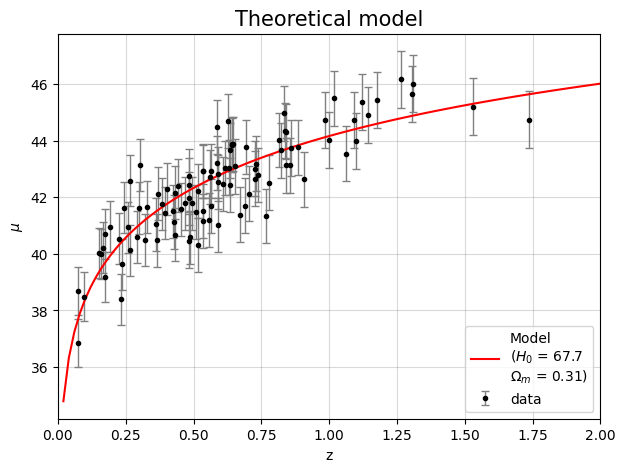

In [6]:
# Theoretical values:
Om_theo = Planck18.Om0
H0_theo = Planck18.H0.value 

grid_theo_model = np.linspace(0, 2, 100)[1:]
mu_theo_model = model(grid_theo_model, H0_theo, Om_theo)

plt.figure(figsize=(7, 5))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=3, lw=1, label='data')

plt.plot(grid_theo_model, mu_theo_model, ls = '-', color = 'red', lw = 1.5, label = 'Model\n($H_0$ = %.1f\n$\\Omega_m$ = %.2f)' % (H0_theo, Om_theo))

plt.xlabel('z')
plt.ylabel('$\\mu$')
plt.title('Theoretical model', fontsize = 15)
plt.legend(loc='lower right')
plt.grid(alpha=0.3, c='gray')
plt.xlim(0,2)

plt.show()

We can first try to estimate the parameters with MCMC:

### MCMC


In [7]:
def lnPrior(par):     # Step prior

    H0, Om = par
    if 50 < H0 < 100 and 0.1 < Om < 1:
        return 0.0
    return -np.inf


def lnLikelihood(par, mu_sample, dmu):     # Gaussian likelihood

    H0, Om = par    
    if Om < 0:
        return -np.inf
    else:
        mu_model = model(z_sample, H0, Om)
    return -0.5 * np.sum((mu_sample-mu_model)**2/(dmu**2))


def lnPosterior(par, z_sample, mu_sample, dmu):
    return lnLikelihood(par, mu_sample, dmu) + lnPrior(par)

In [8]:
ndim = 2
nwalkers = 10
nsteps = 10000

par = [75, 0.5]

In [9]:
starting_guesses = par + np.random.normal(loc=0, scale=0.1, size=(nwalkers, ndim))
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnPosterior, args=[z_sample, mu_sample, dmu])
sampler.run_mcmc(starting_guesses, nsteps, progress = True)

samples = sampler.get_chain()

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:07<00:00, 40.47it/s]


In [10]:
print(sampler.chain.shape)     # (nwalkers x nsteps x ndim)
print(samples.shape)     # (nsteps x nwalkers x ndim)

(10, 10000, 2)
(10000, 10, 2)


In [11]:
tau = sampler.get_autocorr_time()
print(tau)

flat_samples = sampler.get_chain(discard=5*int(max(tau)), thin=int(max(tau)), flat=True)
print(flat_samples.shape)

[42.21074422 43.99069786]
(2270, 2)


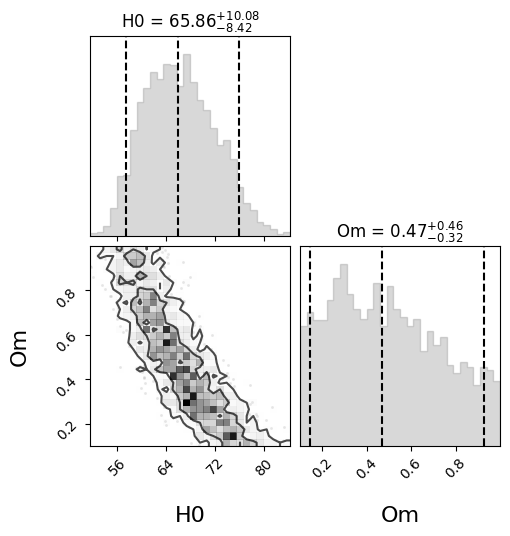

In [13]:
# Corner plots
quantiles = [0.05, 0.5, 0.95]
levels = [0.68, 0.95]
labels = ['H0', 'Om']
fig = corner.corner(flat_samples, labels=labels, plot_datapoints = True, levels=levels, quantiles=quantiles, bins = 30,
                    show_titles=True,
                   label_kwargs={"fontsize": 16}, hist_kwargs={"fill": True, "color": "grey", "alpha": 0.3},
                   contour_kwargs={"colors": "black", "alpha": 0.7}, use_math_text=True)
plt.show()

From this estimation, we can observe that the parameters are correlated.

Let's see how well these parameters fit the data by extracting 100 random sets:

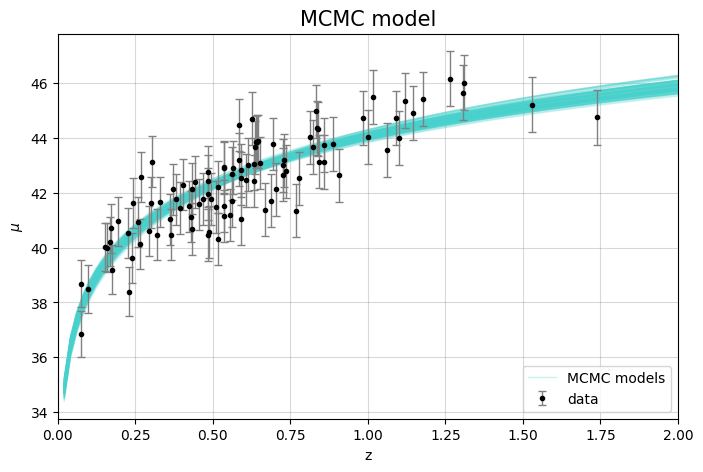

In [14]:
random_samples= flat_samples[np.random.choice(len(flat_samples),size=100)]

plt.figure(figsize=(8, 5))

mcmc_model = np.empty(shape=grid.shape)
first_it = True     # I want to print the label only once

for H0, Om in random_samples:

    for i, z in enumerate(grid):
        mcmc_model[i] = model(z, H0, Om)

    if (first_it == True):
        plt.plot(grid, mcmc_model, lw = 1, c = 'mediumturquoise', alpha = 0.3, label = 'MCMC models')    
        first_it = False
        
    plt.plot(grid, mcmc_model, lw = 1, c = 'mediumturquoise', alpha = 0.3)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=3, lw=1, label='data')
plt.xlabel('z')
plt.ylabel('$\\mu$')
plt.title('MCMC model', fontsize = 15)
plt.legend(loc='lower right')
plt.grid(alpha=0.3, c='gray')
plt.xlim(0,2)

plt.show()

The models extracted fit the data pretty well! But, the parameters have high uncertainties.

We can try estimating the parameters with a nested sampling, testing also the hypothesis of "no dark energy" in the meantime.

### Nested sampling and "No dark energy" model

In [15]:
def model_DE(z, H0, Om):     # Same as before, just renamed

    cosmo_tmp = LambdaCDM(H0=H0, Om0=Om, Ode0=1-Om)
    mu_model_DE = cosmo_tmp.distmod(z).value
    return  mu_model_DE

def model_no_DE(z, H0):

    cosmo_tmp = LambdaCDM(H0=H0, Om0=1, Ode0 = 0)
    mu_model_no_DE = cosmo_tmp.distmod(z).value
    return  mu_model_no_DE
    
#----------------------------------------------------------------------------------------

def prior_transform_DE(u):
        
    H0_min, H0_max = 50, 100
    Om_min, Om_max = 0.1, 1
    H0 = scipy.stats.uniform(loc=H0_min,scale=H0_max-H0_min).ppf(u[0])
    Om = scipy.stats.uniform(loc=Om_min,scale=Om_max-Om_min).ppf(u[1])

    return H0, Om

def prior_transform_no_DE(u):

    H0_min, H0_max = 50, 100
    H0 = scipy.stats.uniform(loc=H0_min,scale=H0_max-H0_min).ppf(u)

    return H0

#----------------------------------------------------------------------------------------

def lnLike_DE(par, z_sample, mu_sample, dmu):

    H0, Om = par    
    if Om < 0:
        return -np.inf
    else:
        mu_model = model_DE(z_sample, H0, Om)
    
    return -0.5 * np.sum((mu_sample-mu_model)**2/(dmu**2))


def lnLike_no_DE(H0, z_sample, mu_sample, dmu):

    Om = 1
    H0 = float(H0)
    mu_model = model_no_DE(z_sample, H0)
        
    return -0.5 * np.sum((mu_sample-mu_model)**2/(dmu**2))

# Note: I separated the two models like this and not with an if inside the functions because I kept getting errors. They have been resolved, 
# but I prefer to keep the functions as they are now

In [16]:
# First, for the Dark Matter model:

ndim_DE = 2
sampler_DE = NestedSampler(lnLike_DE, prior_transform_DE, ndim_DE, logl_args=[z_sample, mu_sample, dmu])
sampler_DE.run_nested()
results_DE = sampler_DE.results

1542it [01:19, 19.36it/s, +500 | bound: 0 | nc: 1 | ncall: 11187 | eff(%): 19.107 | loglstar:   -inf < -46.386 <    inf | logz: -48.605 +/-  0.041 | dlogz:  0.001 >  0.509]


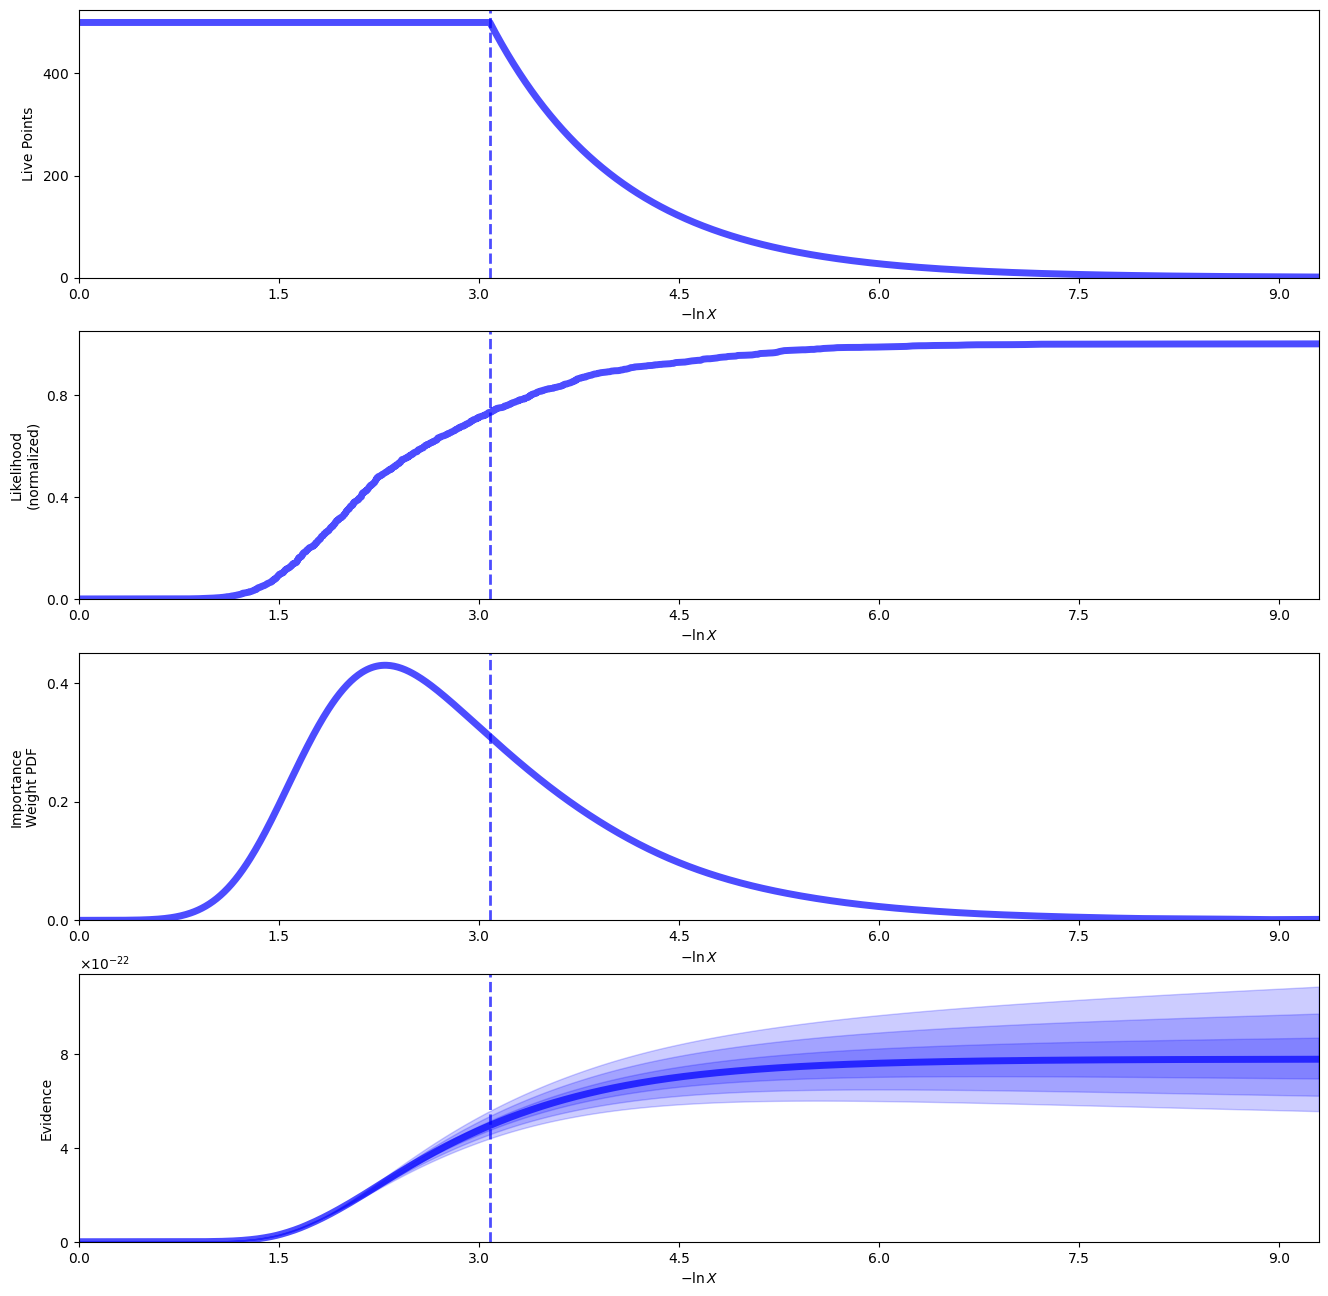

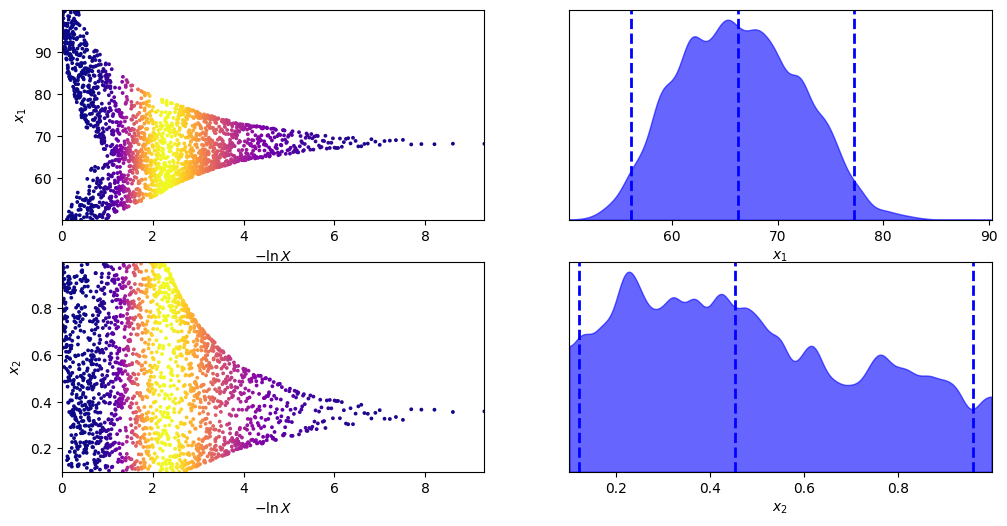

In [17]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(results_DE)
tfig, taxes = dyplot.traceplot(results_DE)
plt.show()

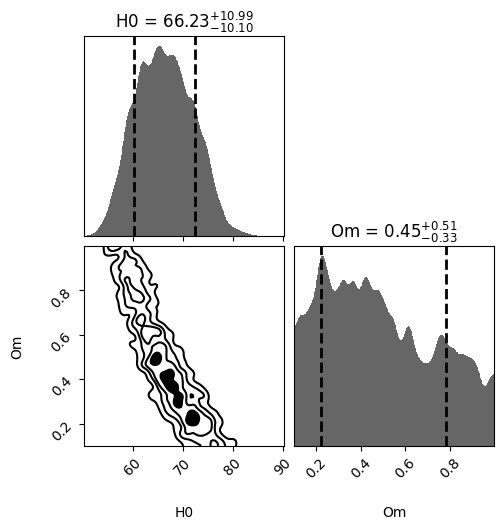

In [18]:
labels = ["H0", "Om"]
fig, axes = dyplot.cornerplot(results_DE, show_titles=True, quantiles=[0.16, 0.84], labels=labels)
plt.show()

The results are very similar to the MCMC ones (though, if our aim was to have smaller uncertainties, it didn't work). The correlation is also the same as before.

Now, for the No dark energy model:

In [19]:
ndim_no_DE = 1
sampler_no_DE = NestedSampler(lnLike_no_DE, prior_transform_no_DE, ndim_no_DE, logl_args=[z_sample, mu_sample, dmu])
sampler_no_DE.run_nested()
results_no_DE = sampler_no_DE.results

C:\Users\lilit\AppData\Local\Temp\ipykernel_13452\1402365492.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  H0 = float(H0)
1529it [00:44, 34.12it/s, +500 | bound: 0 | nc: 1 | ncall: 9694 | eff(%): 22.069 | loglstar:   -inf < -47.102 <    inf | logz: -49.255 +/-  0.035 | dlogz:  0.001 >  0.509]


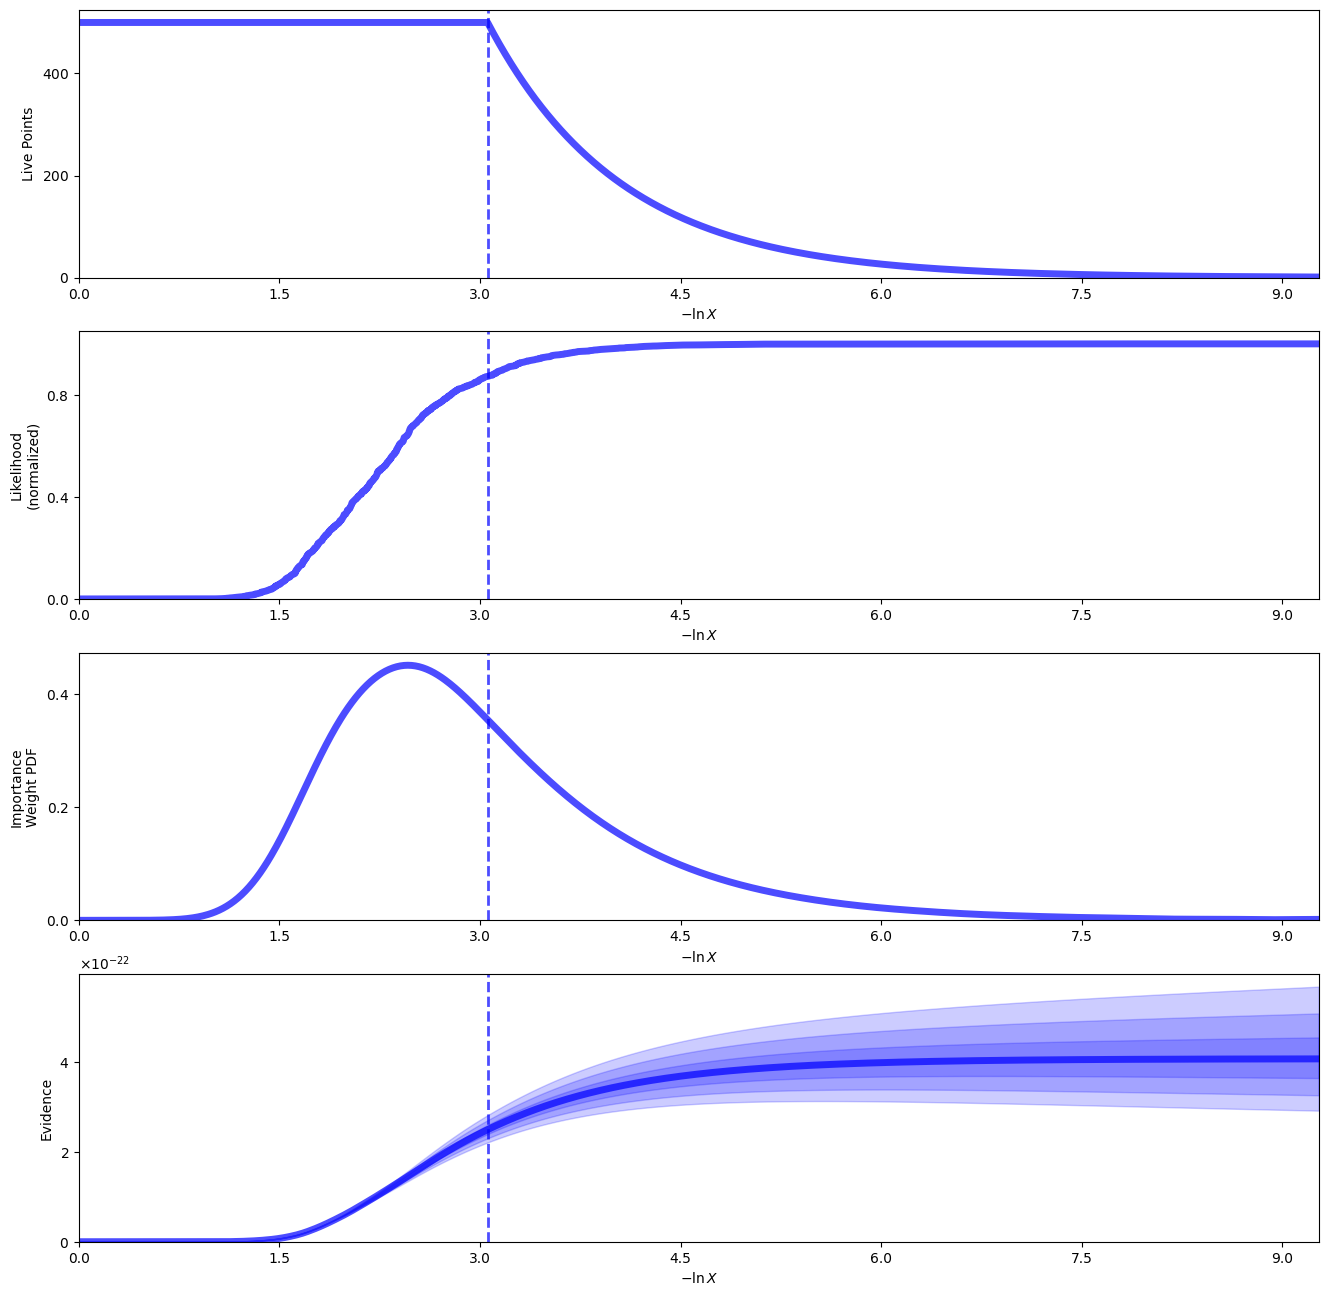

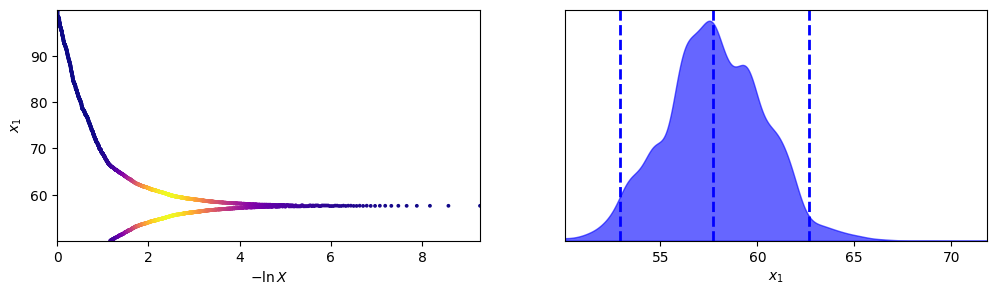

In [20]:
rfig, raxes = dyplot.runplot(results_no_DE)
tfig, taxes = dyplot.traceplot(results_no_DE)
plt.show()

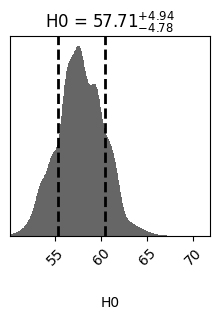

In [21]:
labels = ["H0"]
fig = dyplot.cornerplot(results_no_DE, show_titles=True, quantiles=[0.16, 0.84], labels=labels)
plt.show()

So, the result we obtain for $H_0$ if we consider the "No dark energy" model is lower than the one obtained for the "Dark energy" model. This makes sense in the plot we've found before: rising the value of $\Omega_m$ in the plot meant having lower values for $H_0$. Also, in this case the uncertainties are lower (as one would expect with having a single parameter).

Let's use the Bayes factor to see what model is preferred:

In [22]:
B = np.exp(results_DE.logz[-1])/np.exp(results_no_DE.logz[-1])
print(B)

# For the error:
# A = results_DE.logz[-1]
# C = results_no_DE.logz[-1]
# B = e^A / e^C
# errB = B * (errA^2 + errC^2)^1/2
errA = results_DE.logzerr[-1]
errC = results_no_DE.logzerr[-1]
errB = B * (errA**2 + errC**2)**0.5
print(errB)

print('The Bayes factor between the two models is B = %.2f +- %.2f' % (B, errB))

1.9141460168792506
0.3012713528373218
The Bayes factor between the two models is B = 1.91 +- 0.30


This means that the evidence of one model against the other is "barely worth mentioning": judging by these data, we can't say if dark energy is present or not in the Universe. 

Let's see how these models fit the data:

In [23]:
# DE model:
samples_DE = results_DE.samples
weights_DE = np.exp(results_DE.logwt - results_DE.logz[-1])  # normalized weights
samples_equal_DE = dyfunc.resample_equal(samples_DE, weights_DE)

random_samples_DE = samples_equal_DE[np.random.choice(len(samples_equal_DE),size=100)]

# no-DE model:
samples_no_DE = results_no_DE.samples
weights_no_DE = np.exp(results_no_DE.logwt - results_no_DE.logz[-1])  # normalized weights
samples_equal_no_DE = dyfunc.resample_equal(samples_no_DE, weights_no_DE)

random_samples_no_DE = samples_equal_no_DE[np.random.choice(len(samples_equal_no_DE),size=100)]

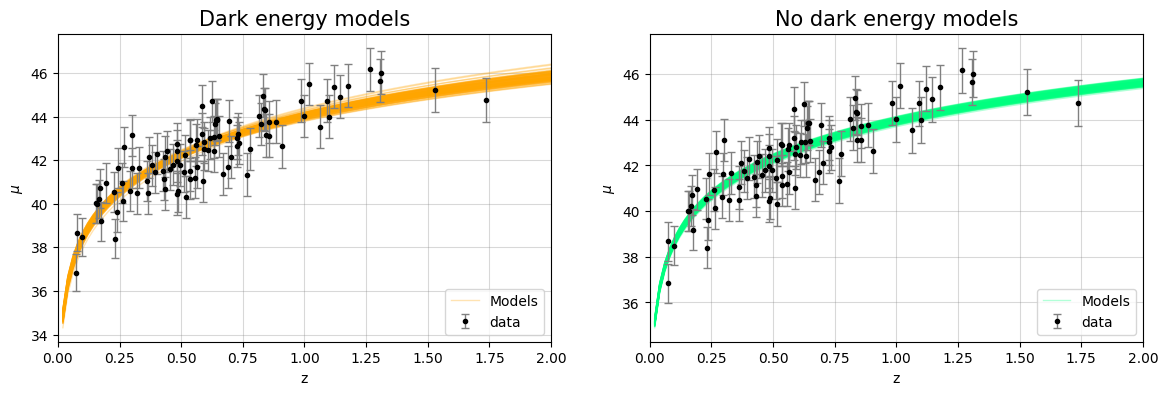

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

DE_points = np.empty(shape=grid.shape)     # To draw the models
first_it = True

for H0, Om in random_samples_DE:

    for i, z in enumerate(grid):
        DE_points[i] = model_DE(z, H0, Om)

    if (first_it == True):
        ax[0].plot(grid, DE_points, lw = 1, c = 'orange', alpha = 0.3, label = 'Models')    
        first_it = False
        
    ax[0].plot(grid, DE_points, lw = 1, c = 'orange', alpha = 0.3)

ax[0].errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=3, lw=1, label='data')
ax[0].set_xlabel('z')
ax[0].set_ylabel('$\\mu$')
ax[0].set_title('Dark energy models', fontsize = 15)
ax[0].legend(loc='lower right')
ax[0].grid(alpha=0.3, c='gray')
ax[0].set_xlim(0, 2)

#----------------------------------------------------------------------------------------

no_DE_points = np.empty(shape=grid.shape)
first_it = True

for H0 in random_samples_no_DE:

    H0 = float(H0[0])
    
    for i, z in enumerate(grid):
        no_DE_points[i] = model_no_DE(z, H0)

    if (first_it == True):
        ax[1].plot(grid, no_DE_points, lw = 1, c = 'springgreen', alpha = 0.3, label = 'Models')    
        first_it = False
        
    ax[1].plot(grid, no_DE_points, lw = 1, c = 'springgreen', alpha = 0.3)

ax[1].errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=3, lw=1, label='data')
ax[1].set_xlabel('z')
ax[1].set_ylabel('$\\mu$')
ax[1].set_title('No dark energy models', fontsize = 15)
ax[1].legend(loc='lower right')
ax[1].grid(alpha=0.3, c='gray')
ax[1].set_xlim(0, 2)

plt.show()


## Tasks - part 3

The European Space Agency is considering new cosmology-related space mission. They ask you to figure out what science you can do with 10 times more measurement compared to what you have right now. That is: you want to clone your data. We've seen this earlier in the class, but now we can do much much better.

- Think about the pdf of these data in $z$.
- Using both the GPR fit and your latest $\Lambda$CDM fit, generate a set of $\mu$ measurements that respects the statistical properties of the data you were given.

### Cloning the data

In [25]:
# Starting with uniform draws in z

N = 1000

z_clones = np.random.uniform(0, 2, N)

mu_gpr = []
mu_mcmc = []
mu_nested_DE = []
mu_nested_no_DE = []

for z in z_clones:

    # First, the gpr: for a given z, I want to extract a point from the gaussian centered around the mu value
    # predicted by the gpr, that also gives me the standard deviation.
    mu_fit, sigma = gp.predict([[z]], return_std = True)
    mu_gpr.append(np.random.normal(loc = mu_fit, scale = sigma))

    # For the mcmc: for each z, I want to extract a set of parameters and compute the mu from the model
    H0_mcmc, Om_mcmc = flat_samples[np.random.choice(flat_samples.shape[0])]
    mu_mcmc.append(model(z, H0_mcmc, Om_mcmc))
    
    # Same thing for the nested samplings
    H0_DE, Om_DE = samples_equal_DE[np.random.choice(samples_equal_DE.shape[0])]
    mu_nested_DE.append(model_DE(z, H0_DE, Om_DE))

    H0_no_DE = samples_equal_no_DE[np.random.choice(samples_equal_no_DE.shape[0])]
    H0_no_DE = float(H0_no_DE[0])
    mu_nested_no_DE.append(model_no_DE(z, H0_no_DE))

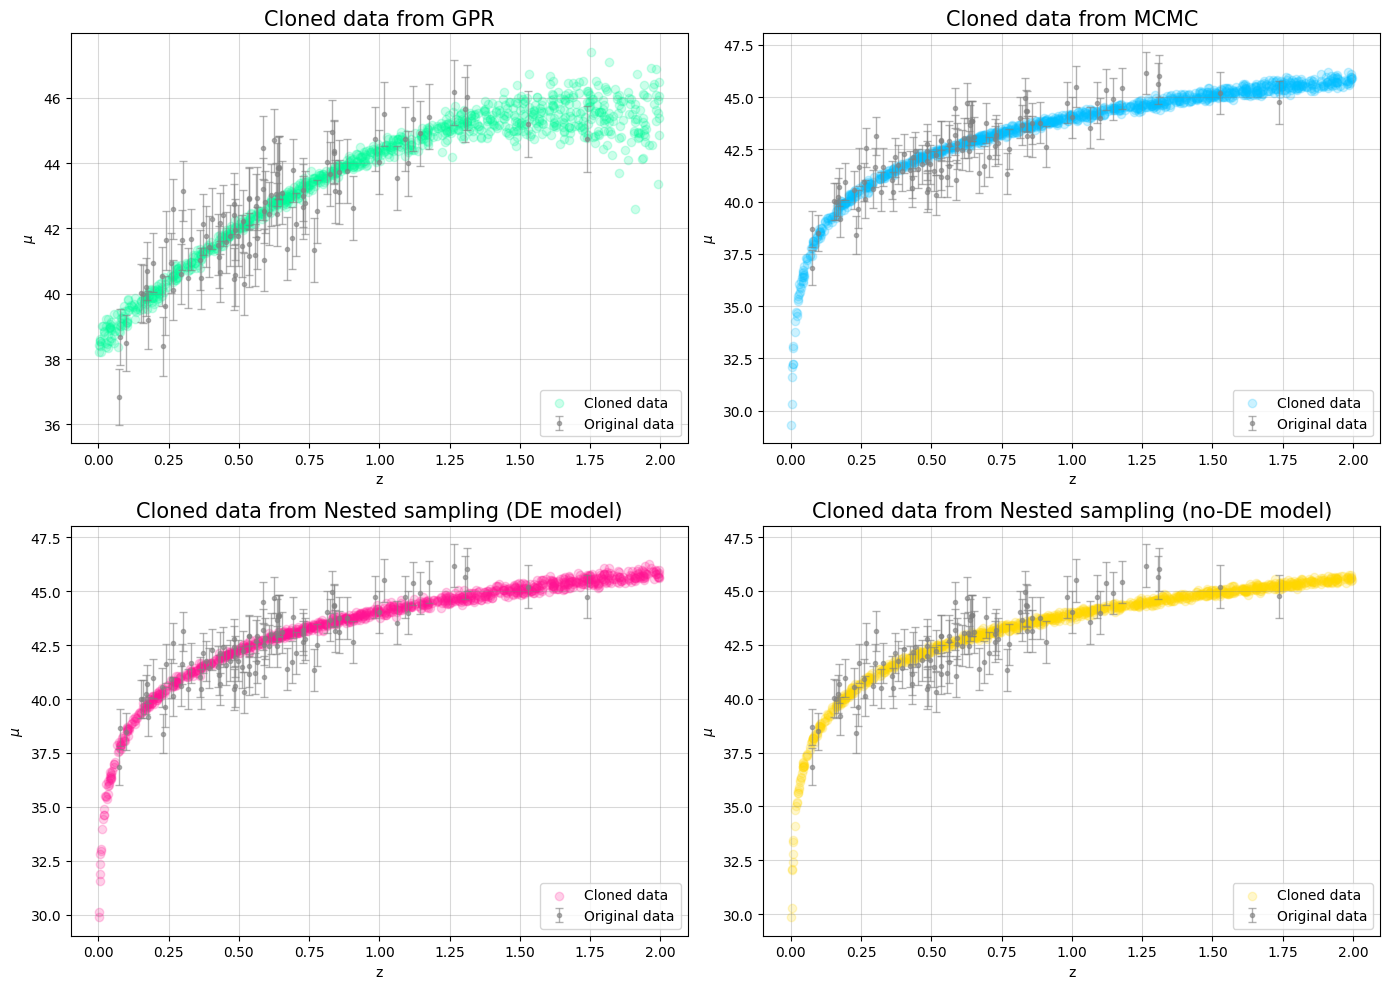

In [26]:
fig = plt.figure(figsize=(14, 10))

titles = ['GPR', 'MCMC', 'Nested sampling (DE model)', 'Nested sampling (no-DE model)']
axes = []

for i in range(4):
    ax = fig.add_subplot(2,2,1+i)
    axes.append(ax)
    ax.errorbar(z_sample, mu_sample, dmu, fmt='grey', ls = '', marker = 'o', markersize = 3, alpha = 0.6, ecolor='gray', capsize=3, lw=1, label= 'Original data')
    ax.grid(c='grey', alpha = 0.2)
    ax.set_xlabel('z')
    ax.set_ylabel('$\\mu$')
    ax.set_title('Cloned data from ' + str(titles[i]), fontsize = 15)
    ax.grid(alpha=0.3, c='gray')
    
axes[0].scatter(z_clones, mu_gpr, c = 'mediumspringgreen', alpha = 0.2, label = 'Cloned data')
axes[1].scatter(z_clones, mu_mcmc, c = 'deepskyblue', alpha = 0.2, label = 'Cloned data')
axes[2].scatter(z_clones, mu_nested_DE, c = 'deeppink', alpha = 0.2, label = 'Cloned data')
axes[3].scatter(z_clones, mu_nested_no_DE, c = 'gold', alpha = 0.2, label = 'Cloned data')

for ax in axes:
        ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

We cloned the data, getting ten times the original ones. The GPR ones have a larger spread for high z, while the MCMC and Nested sampling ones have smaller uncertainties.

But, we did so with a uniform distribution for z. If those data were to truly mirror the original ones, we should have fewer points for high z. We can clone the z distribution, too, to see how the results change; to do so, we perform a KDE on z_samples and then extract 1000 z_clones from it.

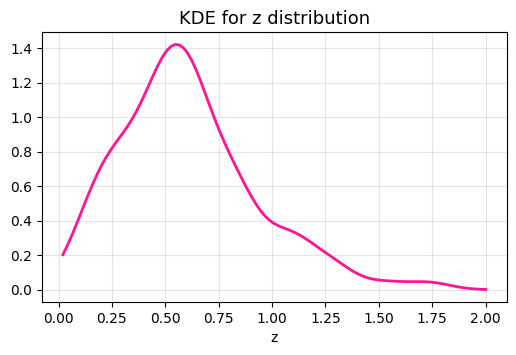

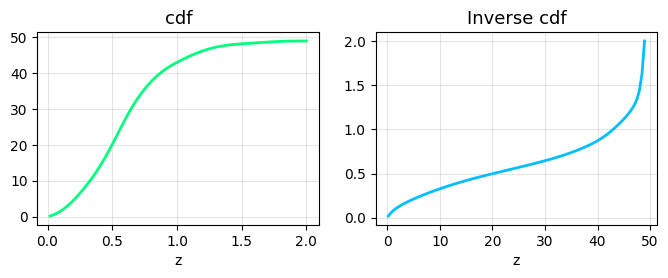

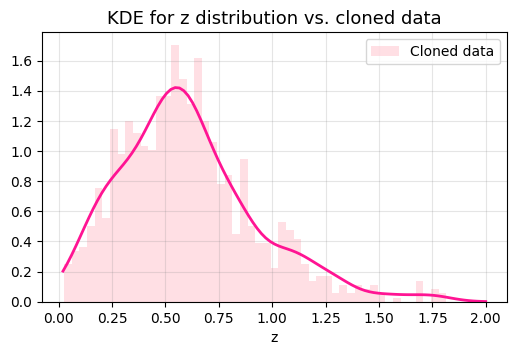

In [62]:
N = 1000

def kde_sklearn(data, bandwidth, xgrid):
    kde_skl = KernelDensity(bandwidth = bandwidth, kernel='gaussian')
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis])

    return np.exp(log_pdf)


pdf = kde_sklearn(z_sample, bandwidth=0.1, xgrid=grid)

plt.figure(figsize = (6, 3.5))
plt.plot(grid, pdf, c = 'deeppink', lw = 2)
plt.title('KDE for z distribution', fontsize = 13)
plt.xlabel('z')
plt.grid(c='grey', alpha = 0.2)
plt.show()


# Computing the cdf and the inverse cdf:
cdf = np.cumsum(pdf)
inv_cdf = scipy.interpolate.interp1d(cdf, grid)

fig, ax = plt.subplots(1, 2, figsize = (8, 2.5))
ax[0].plot(grid, cdf, c = 'springgreen', lw = 2)
ax[0].set_title('cdf', fontsize = 13)
ax[0].set_xlabel('z')
ax[0].grid(c='grey', alpha = 0.2)

x = np.linspace(min(cdf), max(cdf), 100)
ax[1].plot(x, inv_cdf(x), c = 'deepskyblue', lw = 2)
ax[1].set_title('Inverse cdf', fontsize = 13)
ax[1].set_xlabel('z')
ax[1].grid(c='grey', alpha = 0.2)

plt.show()


# Cloning z:
points = np.random.uniform(min(cdf), max(cdf), N)
z_clones = inv_cdf(points)

plt.figure(figsize = (6, 3.5))
plt.plot(grid, kde_values, c = 'deeppink', lw = 2)
plt.hist(z_clones, bins = 50, density = True, color = 'pink', alpha = 0.5, label = 'Cloned data')
plt.title('KDE for z distribution vs. cloned data', fontsize = 13)
plt.xlabel('z')
plt.grid(c='grey', alpha = 0.2)
plt.legend(loc='best')
plt.show()

With these new cloned points, we can repeat the process seen before:

In [28]:
mu_gpr = []
mu_mcmc = []
mu_nested_DE = []
mu_nested_no_DE = []

for z in z_clones:

    mu_fit, sigma = gp.predict([[z]], return_std = True)
    mu_gpr.append(np.random.normal(loc = mu_fit, scale = sigma))

    H0_mcmc, Om_mcmc = flat_samples[np.random.choice(flat_samples.shape[0])]
    mu_mcmc.append(model(z, H0_mcmc, Om_mcmc))
    
    H0_DE, Om_DE = samples_equal_DE[np.random.choice(samples_equal_DE.shape[0])]
    mu_nested_DE.append(model_DE(z, H0_DE, Om_DE))

    H0_no_DE = samples_equal_no_DE[np.random.choice(samples_equal_no_DE.shape[0])]
    H0_no_DE = float(H0_no_DE[0])
    mu_nested_no_DE.append(model_no_DE(z, H0_no_DE))

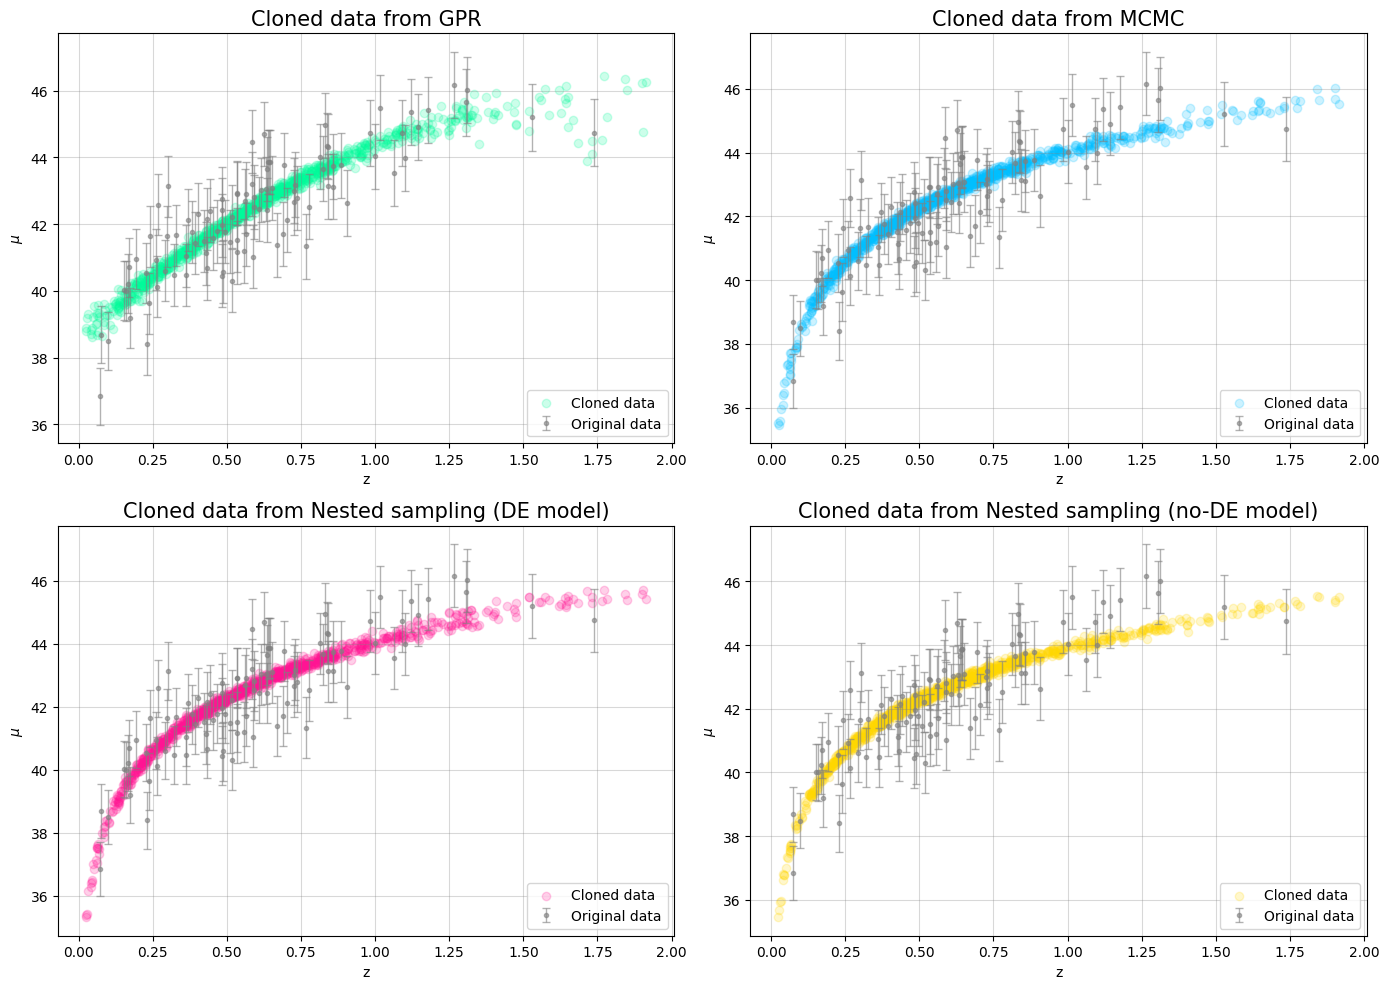

In [29]:
fig = plt.figure(figsize=(14, 10))
axes = []

for i in range(4):
    ax = fig.add_subplot(2,2,1+i)
    axes.append(ax)
    ax.errorbar(z_sample, mu_sample, dmu, fmt='grey', ls = '', marker = 'o', markersize = 3, alpha = 0.6, ecolor='gray', capsize=3, lw=1, label= 'Original data')
    ax.grid(c='grey', alpha = 0.2)
    ax.set_xlabel('z')
    ax.set_ylabel('$\\mu$')
    ax.set_title('Cloned data from ' + str(titles[i]), fontsize = 15)
    ax.grid(alpha=0.3, c='gray')
    
axes[0].scatter(z_clones, mu_gpr, c = 'mediumspringgreen', alpha = 0.2, label = 'Cloned data')
axes[1].scatter(z_clones, mu_mcmc, c = 'deepskyblue', alpha = 0.2, label = 'Cloned data')
axes[2].scatter(z_clones, mu_nested_DE, c = 'deeppink', alpha = 0.2, label = 'Cloned data')
axes[3].scatter(z_clones, mu_nested_no_DE, c = 'gold', alpha = 0.2, label = 'Cloned data')

for ax in axes:
        ax.legend(loc='lower right')

plt.tight_layout()
plt.show()